In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from scipy import stats
import pandas as pd
import numpy as np
from scipy import stats


In [2]:
df = pd.read_csv("data/train.csv")
# df.info()
# df.head()

In [3]:
df = df.drop_duplicates()

In [4]:
def info_with_nones(df):
    """Displays info only for columns with missing values."""
    null_counts = df.isnull().sum()
    cols_with_nones = null_counts[null_counts > 0].index
    couter = 0
    if not cols_with_nones.empty:
        for col in cols_with_nones:
            couter = couter+1
            print(f"Column: {col}")
            print(f"Non-Null Count: {df[col].count()}")
            print(f"Null Count: {df[col].isnull().sum()}")
            print(f"Dtype: {df[col].dtype}")
            print("-" * 20)
    else:
        print("No columns with missing values found.")
    print(f'Number of columns with Nones={couter}')
info_with_nones(df)

Column: LotFrontage
Non-Null Count: 1201
Null Count: 259
Dtype: float64
--------------------
Column: Alley
Non-Null Count: 91
Null Count: 1369
Dtype: object
--------------------
Column: MasVnrType
Non-Null Count: 1452
Null Count: 8
Dtype: object
--------------------
Column: MasVnrArea
Non-Null Count: 1452
Null Count: 8
Dtype: float64
--------------------
Column: BsmtQual
Non-Null Count: 1423
Null Count: 37
Dtype: object
--------------------
Column: BsmtCond
Non-Null Count: 1423
Null Count: 37
Dtype: object
--------------------
Column: BsmtExposure
Non-Null Count: 1422
Null Count: 38
Dtype: object
--------------------
Column: BsmtFinType1
Non-Null Count: 1423
Null Count: 37
Dtype: object
--------------------
Column: BsmtFinType2
Non-Null Count: 1422
Null Count: 38
Dtype: object
--------------------
Column: Electrical
Non-Null Count: 1459
Null Count: 1
Dtype: object
--------------------
Column: FireplaceQu
Non-Null Count: 770
Null Count: 690
Dtype: object
--------------------
Column: Gar

In [5]:
df['Alley']=df['Alley'].fillna("NoAlley")

df['PoolQC']=df['PoolQC'].fillna("NoPool")

df['MiscFeature']=df['MiscFeature'].fillna("NoFeature")

df['Fence']=df['Fence'].fillna("NoFence")

df['MasVnrType']=df['MasVnrType'].fillna("NoMasonry")

df['FireplaceQu']=df['FireplaceQu'].fillna("NoFirePlace")

df['BsmtQual']=df['BsmtQual'].fillna("NoBasement")
df['BsmtCond']=df['BsmtCond'].fillna("NoBasement")
df['BsmtExposure']=df['BsmtExposure'].fillna("NoBasement")
df['BsmtFinType1']=df['BsmtFinType1'].fillna("NoBasement")
df['BsmtFinType2']=df['BsmtFinType2'].fillna("NoBasement")

df['GarageType']=df['GarageType'].fillna("NoGarage")
df['GarageYrBlt']=df['GarageYrBlt'].fillna("NoGarage")
df['GarageFinish']=df['GarageFinish'].fillna("NoGarage")
df['GarageQual']=df['GarageQual'].fillna("NoGarage")
df['GarageCond']=df['GarageCond'].fillna("NoGarage")

In [6]:
info_with_nones(df)


Column: LotFrontage
Non-Null Count: 1201
Null Count: 259
Dtype: float64
--------------------
Column: MasVnrArea
Non-Null Count: 1452
Null Count: 8
Dtype: float64
--------------------
Column: Electrical
Non-Null Count: 1459
Null Count: 1
Dtype: object
--------------------
Number of columns with Nones=3


deal with real Nones:
LotFrontage
MasVnrArea

In [7]:
df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [8]:

def impute_column_knn_sklearn(df, column_name, k=5):
    """Imputes a column using sklearn's KNNImputer."""
    df_numeric = df.select_dtypes(include=np.number)
    imputer = KNNImputer(n_neighbors=k)
    df_imputed = imputer.fit_transform(df_numeric)
    df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns, index=df.index)
    df[column_name] = df_imputed[column_name]
    return df

def calculate_ks_statistic(df_original, df_imputed, column_name):
    """Calculates the KS statistic between original and imputed distributions."""
    original_data = df_original[column_name].dropna()
    imputed_data = df_imputed[column_name]
    ks_statistic, p_value = stats.ks_2samp(original_data, imputed_data)
    return ks_statistic, p_value



In [9]:


def compare_imputation_with_k(df, column_name, k_values):
    """Compares KNN imputation for different k values using KS statistic and Wasserstein Distance."""
    results = {}
    for k in k_values:
        df_imputed_knn = impute_column_knn_sklearn(df.copy(), column_name, k=k)

        ks_stat, ks_pval = calculate_ks_statistic(df.dropna(), df_imputed_knn, column_name)
        results[k] = {'KS Statistic': ks_stat, 'KS P-Value': ks_pval}

    return results

k_values = [1, 2, 3]  
comparison_results = compare_imputation_with_k(df, 'LotFrontage', k_values)

for k, metrics in comparison_results.items():
    print(f"k = {k}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

k = 1:
  KS Statistic: 0.010225786466579474
  KS P-Value: 0.9999995704783942
k = 2:
  KS Statistic: 0.023534338358458962
  KS P-Value: 0.8486757217938714
k = 3:
  KS Statistic: 0.033808310961198684
  KS P-Value: 0.42831773746357865


Above is not satisfactory, since for k=1 we certainly overfit when imputing the data (no wonder p-value=1). To find the optimal imputation scheme we will use cross-validation.

In [10]:
def evaluate_imputer_generalization(df, column_name, k_values, test_size=0.2, random_state=42):
    """Evaluates KNN imputer generalization using train-test split."""
    results = {}
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    train_numeric = train_df.select_dtypes(include=np.number)
    test_numeric = test_df.select_dtypes(include=np.number)

    original_test_data = test_df[column_name].dropna()

    for k in k_values:
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(train_numeric)  
        test_imputed = imputer.transform(test_numeric) 
        test_imputed_df = pd.DataFrame(test_imputed, columns=test_numeric.columns, index=test_df.index)
        imputed_test_data = test_imputed_df[column_name]

        ks_stat, _ = stats.ks_2samp(original_test_data, imputed_test_data)
        results[k] = ks_stat

    return results


k_values = [2, 3, 5, 7, 9]
results = evaluate_imputer_generalization(df, 'LotFrontage', k_values)

for k, ks_stat in results.items():
    print(f"k = {k}: KS Statistic (Test Set) = {ks_stat:.4f}")

best_k = min(results, key=results.get)
print(f"The best k value on the test set is: {best_k}")

k = 2: KS Statistic (Test Set) = 0.0204
k = 3: KS Statistic (Test Set) = 0.0170
k = 5: KS Statistic (Test Set) = 0.0177
k = 7: KS Statistic (Test Set) = 0.0308
k = 9: KS Statistic (Test Set) = 0.0348
The best k value on the test set is: 3


In [11]:
def impute_column_mean(df, column_name):
    """Imputes a column using the mean."""
    mean_value = df[column_name].mean()
    df[column_name] = df[column_name].fillna(mean_value)
    return df


def compare_imputation_distributions(df_original, df_mean, df_knn, column_name):
    """Compares the distributions of a column after different imputations with seaborn."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    
    plt.figure(figsize=(12, 6))
    
    # First subplot - original data
    ax1 = plt.subplot(1, 3, 1)
    # Get the original non-missing data as a Series
    original_data = df_original[column_name].dropna()
    
    if len(original_data) > 0:
        # Explicitly convert to a pandas Series with a known valid color
        sns.histplot(original_data.reset_index(drop=True), kde=True, ax=ax1, color='blue')
        ax1.set_title(f'Original {column_name}\n(non-missing values)')
    else:
        ax1.text(0.5, 0.5, "No non-missing values", ha='center', va='center')
        ax1.set_title(f'Original {column_name}')

    # Second subplot - mean imputation
    ax2 = plt.subplot(1, 3, 2)
    # Ensure the data is a pandas Series
    mean_data = df_mean[column_name].reset_index(drop=True)
    sns.histplot(mean_data, kde=True, ax=ax2, color='green')
    ax2.set_title(f'Mean Imputation\n{column_name}')

    # Third subplot - KNN imputation
    ax3 = plt.subplot(1, 3, 3)
    # Ensure the data is a pandas Series
    knn_data = df_knn[column_name].reset_index(drop=True)
    sns.histplot(knn_data, kde=True, ax=ax3, color='red')
    ax3.set_title(f'KNN Imputation\n{column_name}')

    plt.tight_layout()
    plt.show()
    
    
    if len(original_data) > 0:
        print("\nOriginal data stats (non-missing):")
        print(f"Min: {original_data.min():.2f}, Max: {original_data.max():.2f}, Mean: {original_data.mean():.2f}")
    
    print("\nMean imputed stats:")
    print(f"Min: {mean_data.min():.2f}, Max: {mean_data.max():.2f}, Mean: {mean_data.mean():.2f}")
    
    print("\nKNN imputed stats:")
    print(f"Min: {knn_data.min():.2f}, Max: {knn_data.max():.2f}, Mean: {knn_data.mean():.2f}")



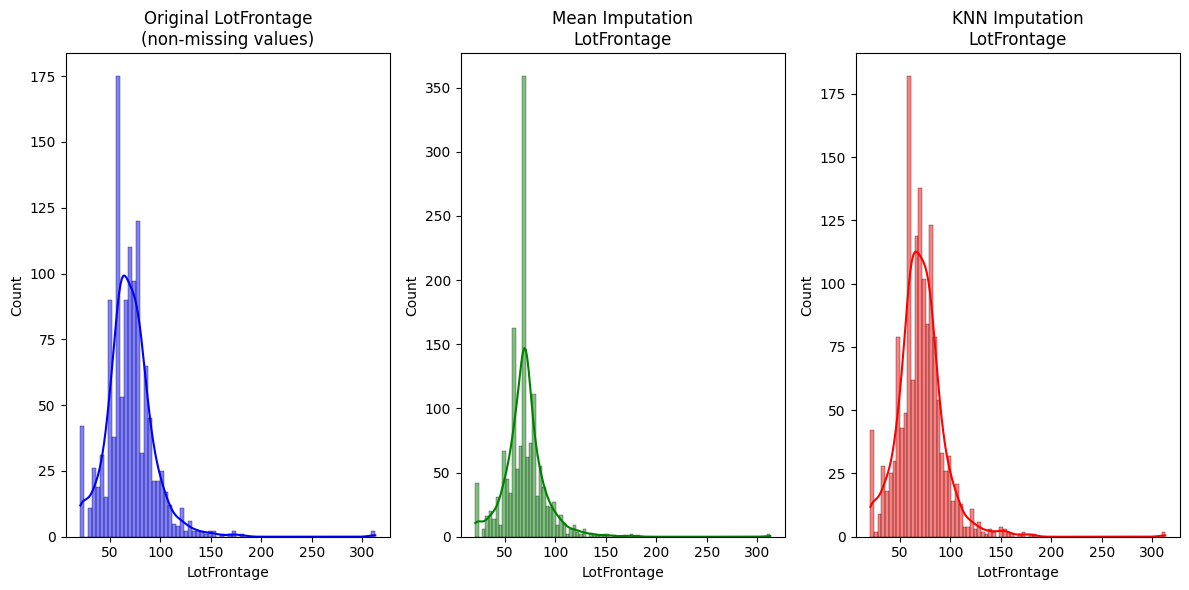


Original data stats (non-missing):
Min: 21.00, Max: 313.00, Mean: 70.05

Mean imputed stats:
Min: 21.00, Max: 313.00, Mean: 70.05

KNN imputed stats:
Min: 21.00, Max: 313.00, Mean: 70.82


In [12]:
df_mean_imputed = impute_column_mean(df.copy(), 'LotFrontage')
df_knn_sklearn_imputed = impute_column_knn_sklearn(df.copy(), 'LotFrontage', k=3)

compare_imputation_distributions(df, df_mean_imputed, df_knn_sklearn_imputed, 'LotFrontage')

Above everything looks right: the distribution after imputation looks similar to original one, certainly better than mean imputation

In [13]:
df = impute_column_knn_sklearn(df.copy(), 'LotFrontage', k=3)
info_with_nones(df)

Column: MasVnrArea
Non-Null Count: 1452
Null Count: 8
Dtype: float64
--------------------
Column: Electrical
Non-Null Count: 1459
Null Count: 1
Dtype: object
--------------------
Number of columns with Nones=2


Since only 8 are missing Ma

In [14]:
print(df['MasVnrArea'].describe(), '\n',"the median is", df['MasVnrArea'].median())

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64 
 the median is 0.0


In [15]:
def impute_column_median(df, column_name):
    """Imputes a column using the median."""
    median_value = df[column_name].median()
    df[column_name] = df[column_name].fillna(median_value)
    return df

def impute_column_top(df, column_name):
    """Imputes a column using the most common."""
    top_category = df[column_name].value_counts().idxmax()
    df[column_name] = df[column_name].fillna(top_category)
    return df

df = impute_column_median(df.copy(),'MasVnrArea')
df = impute_column_top(df.copy(),'Electrical')

In [16]:
info_with_nones(df)

No columns with missing values found.
Number of columns with Nones=0


In [17]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [18]:
df.to_csv('data/train_cleaned.csv', index=False)